# Sparkify Project

Analysis of `medium_sparkify_event_data.json` dataset using IBM Cloud services.

# Load and Clean Dataset
Load and clean dataset `medium_sparkify_event_data.json`:

In [2]:
# import general libraries for data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import re

In [2]:
# import spark libraries
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import to_date, datediff
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col, sum, mean, stddev, min, max, round
from pyspark.sql import Window

from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

`1.` Load the dataset:

In [3]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-6db02be6-9127-48e0-8f20-d8b49e247c67',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'pyhRDkq55K8ETNvx_wWr2eXFU7QTEMvIh21zKFVketmX'
}

configuration_name = 'os_218bc8cce9124b6f9716ce75acae81c9_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_medium = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkly-donotdelete-pr-xd5vv9g8psteli'))
df_medium.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

`2.` Clean the dataset:

For data cleaning I used the script which is already prepared for the mini dataset:

In [6]:
def clean_data(df):
    '''
    Function which performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify log events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column
    '''
    
    # remove rows where userId is empty
    df_new = df.filter(df["userId"] != "")
    
    return df_new

# clean data
df_medium = clean_data(df_medium)

# print out first line
df_medium.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

# Exploratory Data Analysis

## 1. Preliminary Analysis

`1.1` Get summary for the dataset:

In [6]:
print('There are {} lines in the dataset.  Each line corresponds to an event for a user, who signed in.'\
     .format(df_medium.count()))

There are 528005 lines in the dataset.  Each line corresponds to an event for a user, who signed in.


In [7]:
print('There are {users} unique users in the dataset.'.format( users = df_medium.select('userId').distinct().count()))

There are 448 unique users in the dataset.


`1.2` Analyze number of events for each value of categorical columns ('auth', 'gender', 'level', 'method', 'page'):

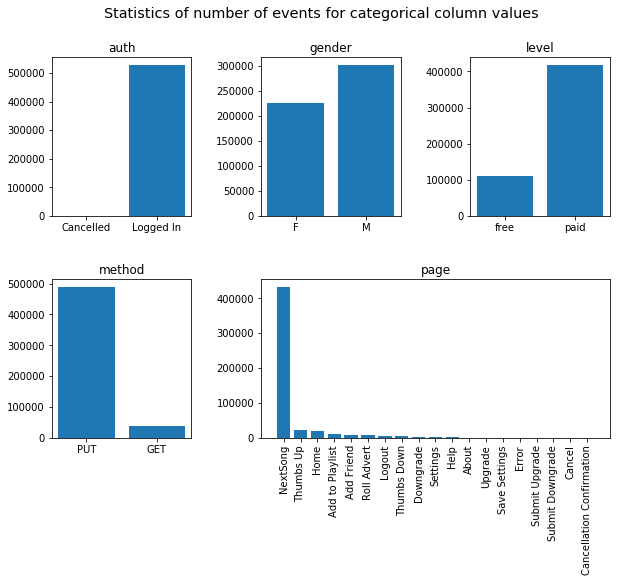

In [8]:
# plot bar charts with number of events with respect to categorical values

cat_columns = ['auth', 'gender', 'level', 'method']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)

counter = 0
for cat_column in cat_columns:
    
    value_counts = df_medium.groupBy(cat_column).count().toPandas()
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    x_pos = np.arange(0, len(value_counts))
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    hist_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts[cat_column].values)
    
    hist_ax.set_title(cat_column)
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts = df_medium.groupBy('page').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

page_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['page'].values)

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

`1.3` Analyze the number of users of dufferent gender and different subscription level:

In [9]:
# calculate the number of female and male users

male = df_medium.select('userId', 'gender').where(df_medium.gender == 'M').groupBy('userId').count().agg(count("count"))
female = df_medium.select('userId', 'gender').where(df_medium.gender == 'F').groupBy('userId').count().agg(count("count"))

print('There are {male} male and {female} female users in dataset.'\
      .format(male = male.collect()[0]["count(count)"],\
             female = female.collect()[0]["count(count)"]))

There are 250 male and 198 female users in dataset.


In [10]:
# calculate the number of paid and free accounts

paid = df_medium.select('userId', 'level').where(df_medium.level == 'paid').groupBy('userId').count().agg(count("count"))
free = df_medium.select('userId', 'level').where(df_medium.level == 'free').groupBy('userId').count().agg(count("count"))

print('There are {paid} paid and {free} free accounts in dataset.'\
      .format(paid = paid.collect()[0]["count(count)"],\
             free = free.collect()[0]["count(count)"]))

There are 321 paid and 370 free accounts in dataset.


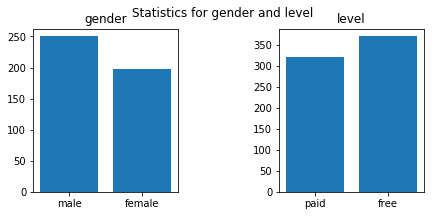

In [11]:
#plot the results

fig = plt.figure(figsize=(7, 3))
st = fig.suptitle("Statistics for gender and level")

grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.7)

x_pos = np.arange(0, 2)

gender_ax = fig.add_subplot(grid[0 , 0])

level_ax = fig.add_subplot(grid[0 , 1])

gender_ax.bar(x_pos, [male.collect()[0]["count(count)"], female.collect()[0]["count(count)"]], \
              tick_label = ['male', 'female'])
gender_ax.set_title('gender')

level_ax.bar(x_pos, [paid.collect()[0]["count(count)"], free.collect()[0]["count(count)"]], \
              tick_label = ['paid', 'free'])
level_ax.set_title('level')

plt.show()

### `1.4` Conclusions:

From the preliminary analysis we can tell that:
* There are more male users than female users in the dataset and the number of events corresponding to male users is greater than the number of events for female users.
* There are fewer paid level users than free level users, but the number of events for paud users is greater than the number of events for free level users. __This means that paid level users are more active users of the service.__

## 2. Define Churn

Create a column `churn` to label users who cancelled subscription and and mark rows for the users, who cancelled subscription, with `churn = 1`.

In [12]:
# create column Churn and mark rows for the users, who cancelled subscription, with Churn = 1

cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# set churn = 1 for rows where page == 'Cancellation Confirmation'
df_medium = df_medium.withColumn("churn", cancellation_event(col("page")))

In [13]:
# get userId with churn == 1
cancelled_users = df_medium.select('userId', 'churn').filter(df_medium['churn'] == 1).distinct()

In [14]:
# get number of users, who churned

print('{} users churned.'.format(cancelled_users.count()))

99 users churned.


In [15]:
# create a list of userIds of the users who churned

cancelled_users_list = [int(row.userId) for row in cancelled_users.collect()]

In [16]:
# set churn == 1 for all rows for users who cancelled their subscription

# create udf, which sets churn of a row to 1 if userId is in cancelled_users list
def fill_array(userId):
    if(int(userId) in cancelled_users_list): return 1
    else : return 0

fill_array_udf = udf(fill_array, IntegerType())

df_medium = df_medium.withColumn("churn", fill_array_udf(col("userId")))

Demonstrate log of events for one of the users who cancelled subscription:

In [17]:
df_medium.select(['userId', 'firstName', 'page', 'churn']).where((df_medium.userId == cancelled_users_list[0])).toPandas().head(5)

,userId,firstName,page,churn
0,100030,Sonia,NextSong,1
1,100030,Sonia,NextSong,1
2,100030,Sonia,NextSong,1
3,100030,Sonia,NextSong,1
4,100030,Sonia,NextSong,1


## 3. Explore Data

Perform exploratory data analysis to observe the behavior for users who stayed vs users who churned.

`3.1` Explore number of users who churned vs number of users who stayed with the service:

In [18]:
# find the number of users who churned and who stayed
churned_users = df_medium.select('userId', 'churn').where(df_medium['churn'] == 1).groupBy('userId').count().count()
stayed_users = df_medium.select('userId', 'churn').where(df_medium['churn'] == 0).groupBy('userId').count().count()

print('The number of users who churned is {}'.format(churned_users))
print('The number of users who didn\'t cancel subscription is {}'.format(stayed_users))

The number of users who churned is 99
The number of users who didn't cancel subscription is 349


We can see that __the dataset is imbalanced__: number of users who churned is approximately 3 times less than the number of users who stayed. That is why __accuracy is probably not the best metric to evaluate our future machine learning model__. I suggest to use F1 score to evaluate the model.

`3.2`  Explore number of events with respect to categorical columns for users who churned and for users who kept subscription:

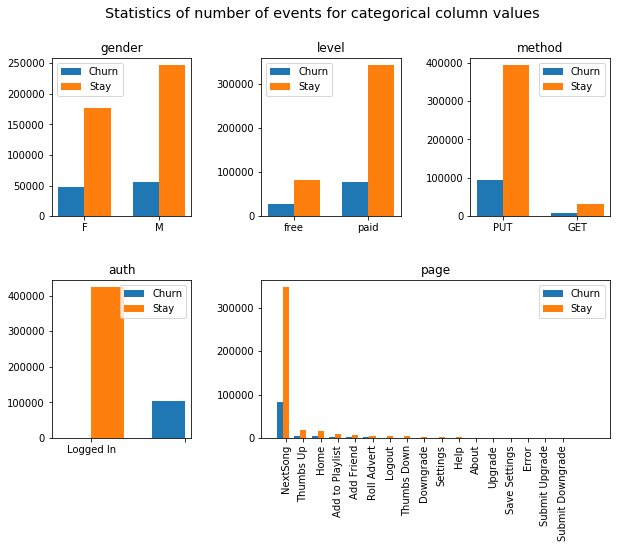

In [20]:
# plot bar charts with values of categorical values

cat_columns = ['gender', 'level', 'method', 'auth']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)
width = 0.35

counter = 0
for cat_column in cat_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    value_counts_ch = df_medium.where(df_medium['churn'] == 1).groupBy(cat_column).count().toPandas()
    value_counts_st = df_medium.where(df_medium['churn'] == 0).groupBy(cat_column).count().toPandas()
    
    x_pos_ch = np.arange(0, len(value_counts_ch))
    x_pos_st = np.arange(0, len(value_counts_st))
        
    p1 = hist_ax.bar(x_pos_ch, value_counts_ch['count'].values, width, \
                     tick_label = value_counts_ch[cat_column].values)
    p2 = hist_ax.bar(x_pos_st + width, value_counts_st['count'].values, width, \
                     tick_label = value_counts_st[cat_column].values)
    
    hist_ax.set_title(cat_column)
    hist_ax.set_xticks(x_pos + width / 2)
    
    hist_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts_ch = df_medium.where(df_medium['churn'] == 1).groupBy('page').count().orderBy('count', ascending=False).toPandas()
value_counts_st = df_medium.where(df_medium['churn'] == 0).groupBy('page').count().orderBy('count', ascending=False).toPandas()
    
x_pos_ch = np.arange(0, len(value_counts_ch))
x_pos_st = np.arange(0, len(value_counts_st))

p1 = page_ax.bar(x_pos_ch, value_counts_ch['count'].values, width, tick_label = value_counts_ch['page'].values)
p2 = page_ax.bar(x_pos_st + width, value_counts_st['count'].values, width, \
                 tick_label = value_counts_st['page'].values)

page_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

`3.4` Explore average song length for users who churned vs users who stayed:

In [25]:
# calculate average song length for the users who churned

avg_length = df_medium.where(df_medium.churn == 1).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+-----------------+
|              mean|              std|
+------------------+-----------------+
|248.99398360601663|98.49278064882218|
+------------------+-----------------+



In [26]:
# calculate average song length for the users who stayed

avg_length = df_medium.where(df_medium.churn == 0).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+-----------------+
|              mean|              std|
+------------------+-----------------+
|248.58486352452857|98.39324443629265|
+------------------+-----------------+



We see that average song length for users who churned is very close to the average song length for the other users.

`3.5`  Explore userAgent column:

In [28]:
# create column for parsed agent
def get_agent(agent):
    agent = agent.split()[0]
    return re.sub(r'[^\w\s]','',agent)
    
get_agent_udf = udf(get_agent, StringType())
df_medium = df_medium.withColumn('agent', get_agent_udf(col('userAgent')))

In [30]:
# select all agent values
df_medium.select('agent').distinct().show()

+---------+
|    agent|
+---------+
|Mozilla50|
+---------+



We see that the 1st user agent is Mozilla for all users. So this column is not informative for this dataset.

`3.6` Explore location column:

In [31]:
# create column for state for each event

def get_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()
    
    return location
    
get_state_udf = udf(get_state, StringType())
df_medium = df_medium.withColumn('state', get_state_udf(col('location')))

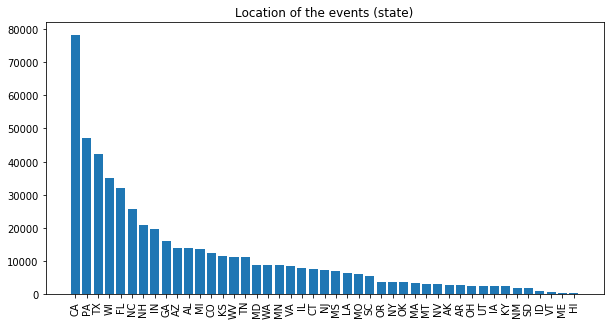

In [33]:
# plot statistics for location of the events
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

value_counts = df_medium.groupBy('state').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['state'].values)

ax.set_title('Location of the events (state)')
    
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [35]:
# calculate number of events for users who churned/stayed for each state

value_counts_ch = df_medium.where(df_medium['churn'] == 1).groupBy('state').count().toPandas().sort_values('state')
value_counts_st = df_medium.where(df_medium['churn'] == 0).groupBy('state').count().toPandas().sort_values('state')

In [36]:
# create lists of states in number of users who churned and stayed

churn_states = value_counts_ch['state'].values.tolist()
for state in value_counts_st['state'].values.tolist():
    if state not in churn_states:
        value_counts_ch = value_counts_ch.append({'state' : state, 'count' : 0}, ignore_index=True)
        
stay_states = value_counts_st['state'].values.tolist()
for state in value_counts_ch['state'].values.tolist():
    if state not in stay_states:
        value_counts_st = value_counts_st.append({'state' : state, 'count' : 0}, ignore_index=True)

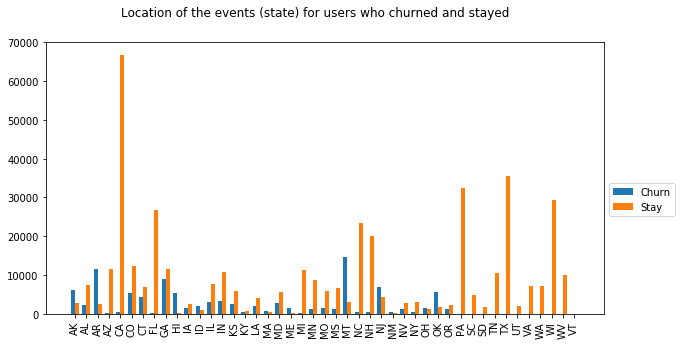

In [37]:
# plot the results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

st = fig.suptitle("Location of the events (state) for users who churned and stayed")

x_pos = np.arange(0, len(value_counts_st['count'].values))
width = 0.35

p1 = ax.bar(x_pos, value_counts_ch['count'].values.tolist(), width, tick_label = value_counts_ch['state'].values.tolist())
p2 = ax.bar(x_pos + width, value_counts_st['count'].values.tolist(), width, tick_label = value_counts_st['state'].values.tolist())

ax.legend((p1[0], p2[0]), ('Churn', 'Stay'), bbox_to_anchor=(1, 0.5))

level_ax.set_title('level')
ax.set_xticks(x_pos + width / 2)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

On the plot above we see that states differ by churn rate: there are states with events related only to users who stayed and there are also states, where there is significant number of events related to users, who churned.

### `3.6` __Conclusions__:
1. We can't say anything about the difference in gender and level for users who churned vs users who stayed, because for these columns the more users/events there are the more there are users/events related to churn.
2. User's agent and song length features are not very informative for the analysis of the churn.
3. Location feature (state of the event) might be informative, because there are states with high and low churn rates.

# Feature Engineering

To predict for each user whether the user is going to churn  we are going extract the following features:
* __gender__, because EDA showed us that male and female users might have different behavior;
* __last level (paid or free)__, because we see that paid level users are more active and also may have different behavior;
* __average events per day__ to see how active the user is in general;
* __average songs per day__ to see how active the user is in listening to the music;
* __number of thumbs up__ to see how satisfied the user is with the content of the service;
* __number of thumbs down__ to see how satisfied the user is with the content of the service;
* __days since the date of first event__ to see how long the user has already been using the service;
* __last location (state)__ the popularity may vary depending on advertising in different regions;
* __number of add friend events__ perhaps the user is less likely to churn if his friends subscribe to the service.

For data engineering I used script prepared for mini dataset:

In [7]:
def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - number of thumbs up events
    6. thumbs_down - number of thumbs down events
    7. active_days - days since user's firts event
    8. last_location - location of the last event
    9. last_level - user's last level (paid or free)
    10. addfriends - number of add friends events
    '''
    
    # clean dataset using clean_data function
    df = clean_data(df)
    
    # add 'churn' column to the original dataset
    
    # define cancellation udf
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    
    # set churn = 1 for rows where page == 'Cancellation Confirmation'
    df = df.withColumn("churn", cancellation_event("page"))
    
    # get userId with churn == 1
    cancelled_users = df.select(['userId', 'churn']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    # create udf, which sets churn of a row to 1 if userId is in cancelled_users list
    def fill_array(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    # set churn == 1 for all rows for users who cancelled their subscription
    fill_array_udf = udf(fill_array, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
    
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))
    
    # convert timestamp to date (string)
    def get_date_from_ts(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date_from_ts, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts')))
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts')))
    
    # add column date and convert timetamp to date
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    # set column last_level to level when timestamp is last timestamp
    df = df.withColumn('last_level',when(df.last_ts == df.ts, df.level))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # create column avg_songs to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
    
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    get_state_udf = udf(get_state, StringType())
    df = df.withColumn('state', get_state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')

    # assemble everything into resulting dataset
    df_ml = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId).distinct()
    df_ml = df_ml.join(events, df_ml.userId == events.events_userId).distinct()
    df_ml = df_ml.join(thumbsup, df_ml.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbsdown, df_ml.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.join(addfriend, df_ml.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['addfriend'])
    df_ml = df_ml.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ml
    
df_medium = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkly-donotdelete-pr-xd5vv9g8psteli'))
df_medium.persist()

df_medium, df_ml = prepare_dataset(df_medium)

In [43]:
df_ml.head()

Row(userId='100010', gender='F', churn=1, last_level='free', days_active=182, last_state='CT', avg_songs=48.0, avg_events=68.5, thumbs_up=4, thumbs_down=3, addfriend=3)

In [44]:
df_ml.show()

+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|userId|gender|churn|last_level|days_active|last_state|avg_songs|avg_events|thumbs_up|thumbs_down|addfriend|
+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|100010|     F|    1|      free|        182|        CT|     48.0|      68.5|        4|          3|        3|
|200002|     M|    1|      paid|        189|        WI|    51.67|     65.83|       15|          5|        2|
|   296|     F|    1|      paid|        188|        NJ|     22.4|      30.4|        8|          0|        2|
|   125|     M|    0|      free|        188|        TX|    20.67|      28.0|        3|          1|        3|
|   124|     F|    1|      paid|        189|        NJ|    86.95|      98.0|      102|         15|       26|
|    51|     M|    1|      paid|        189|        KY|    44.33|     54.67|       16|          1|        3|
|     7|     M|    

In [45]:
df_ml.count() # to check that there are still 448 users and we didn't miss anyone

448

# Modeling

## `1.` Split into Train, Test and Validations Sets:

In [8]:
# split into train, test and validation sets (60% - 20% - 20%)
df_ml = df_ml.withColumnRenamed("churn", "label")

train, test_valid = df_ml.randomSplit([0.6, 0.4], seed = 42)
test, validation = test_valid.randomSplit([0.5, 0.5], seed = 42)

## `2.` Create Machine Learning Pipelines:

 `2.1` Random Forest Classifier:

In [9]:
# index and encode categorical features gender, level and state

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

# initialize random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

In [48]:
model = pipeline.fit(train)

In [49]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [50]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Area under precision-recall curve
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7885304659498208


In [51]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Area under precision-recall curve
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7708333333333334


Try to tune hyperparameters for RF to optimize the results:

In [53]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .build()

#featureSubsetStrategy: auto, all, onethird, sqrt, log2

In [54]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [55]:
cvModel = crossval.fit(train)

In [56]:
bestModel = cvModel.bestModel

In [57]:
pred_test = bestModel.transform(test)

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Area under precision-recall curve
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7916666666666666


In [58]:
# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

In [59]:
validation_results

,f1,impurity,maxDepth,numTrees
0,0.662549,entropy,3,10
1,0.662549,entropy,3,20
2,0.656309,entropy,3,30
3,0.658230,entropy,3,50
4,0.658230,entropy,3,100
5,0.679658,entropy,5,10
6,0.660869,entropy,5,20
7,0.670172,entropy,5,30
8,0.656309,entropy,5,50
9,0.681985,entropy,5,100


 `2.2` Logistic Regression classifier:

In [10]:
# initialize logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, lr])

In [11]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [12]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7598566308243727


In [13]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7708333333333334


Try to tune hyperparameters for LR to optimize the results:

In [14]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 30, 50]) \
    .addGrid(lr.regParam, [0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.8])\
    .addGrid(lr.family, ['auto'])\
    .build()

In [15]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [16]:
cvModel = crossval.fit(train)

In [17]:
bestModel = cvModel.bestModel

predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7598566308243727


In [18]:
# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

validation_results

,elasticNetParam,f1,family,maxIter,regParam
0,0.8,0.662829,auto,10,0.1
1,0.8,0.662829,auto,30,0.1
2,0.8,0.662829,auto,50,0.1
3,0.8,0.662829,auto,10,0.3
4,0.8,0.662829,auto,30,0.3
5,0.8,0.662829,auto,50,0.3


 `2.3` Gradient-boosted tree classifier:

In [19]:
#GBTClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic", maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0)[source]

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, gbt])

In [20]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [21]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.953405017921147


In [22]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.75


Try to tune hyperparameters for GBT to optimize the results:

In [26]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()

In [27]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [ ]:
cvModel = crossval.fit(train)

In [ ]:
# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

validation_results

,f1,maxDepth,maxIter
0,0.679561,2,10
1,0.696031,3,10
2,0.691077,5,10
3,0.685216,2,20
4,0.686541,3,20
5,0.691844,5,20
6,0.698134,2,40
7,0.677590,3,40
8,0.692877,5,40


 `2.4` Naive Bayes classifier:

In [150]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, nb])

In [151]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [152]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.44802867383512546


In [153]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.5416666666666666


Try to tune hyperparameters for NB to optimize the results:

In [154]:
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [1.0, 0.5]) \
    .build()

In [155]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [156]:
cvModel = crossval.fit(train)

In [157]:
# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

validation_results

,f1,smoothing
0,0.492802,1.0
1,0.492669,0.5


`2.5` Compare model evaluation results:

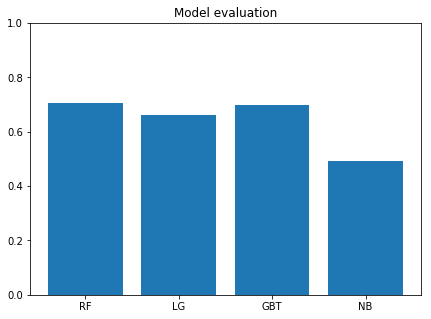

In [6]:
# plot diagram with model evaluation results

models = ['RF', 'LG', 'GBT', 'NB']
performance = [0.705275, 0.662829, 0.698134, 0.492669]

fig, ax = plt.subplots(figsize=(7, 5))

x_pos = np.arange(0, 4)

ax.bar(x_pos, performance, tick_label = models)
ax.set_title('Model evaluation')

plt.ylim(0, 1)
plt.show()

## `3.` Use the Best Model on Validation Dataset

In [31]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, impurity = 'gini', maxDepth = 10)

pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

bestModel = pipeline.fit(train)

pred_validation = bestModel.transform(validation)

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Area under precision-recall curve
print("F1 score on validation dataset is %s" % metrics.fMeasure())

F1 score on validation dataset is 0.75


# Conclusion

The best performance of 75% F1 score was achieved with Random Forest Classifier, but there are ways for the further improvement:
1. Use the largest dataset. The more training data we have the more accurate model we can achieve.
2. Try to think of more meaningful features. 
3. Use feature preprocessing like feature scaling to raise accuracy. This might help to raise accuracy of methods which rely on distance between points, like Naive Bayes classifier.
4. Do more fine tuning of the hyperparameters.
5. Perform model stacking: assemble several completely different models.